In [919]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd

#### DEFINE VARIABLES

In [23]:
PATH = 'data/radar/'
DAY = os.listdir(PATH)[0]

#### READ FIRST FILES TO LOAD GLOBAL VARIABLES

In [112]:
first_file = PATH+str(DAY)+'/'+str(os.listdir(PATH+str(DAY))[0])
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')
    
RUNIT = xds.rain_rate.units
RKM = xds.rain_rate.height_km
LON = xds.lon0.data                 ### Coordinate Longitude Matrix
LAT = xds.lat0.data                 ### Corrdinate Latitude Matrix
X0 = xds.x0                         ### Matrix of points
Y0 = xds.y0
RADAR = (np.median(LON),np.median(LAT))

#### READ TIMES

In [126]:
def read_data(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # Define container
    frames = np.zeros( (interval, nx, ny ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

In [1068]:
def pre_processing(time):
    np.warnings.filterwarnings('ignore')
    
    ## thereshold value to track
    threshold = 21.8
    
    rs =  (np.where(time != np.nan) and np.where(time > threshold))
    rs = np.asanyarray(rs)
    pe = pd.DataFrame({'x1':rs[0],'y1':rs[1]})
        
    return pe

In [1069]:
def clusterization(time):
    te = time
    
    if len(te) < 10:
        return None
    
    bandwidth = estimate_bandwidth(te, quantile=0.3, n_samples=None, random_state=0, n_jobs=None)
    
    if bandwidth > 0:
        ms = MeanShift(bandwidth=5, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)
    else:
        ms = MeanShift(bandwidth=10, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    te['cluster']=labels
    
    return te

In [1070]:
def create_data(day,time,frames,clusters):
    
    data = pd.DataFrame(columns=['DATETIME', 'N_CLUSTER','ID_CLUST','LON','LAT','R_FALL','DBZ'])

    # get values datetime
    dtime = xr.open_dataset(str(PATH)+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[time])).start_time.values
    
    lat = (LAT[clusters['x1'],clusters['y1']])
    lon = (LON[clusters['x1'],clusters['y1']])
    
    # get values from RAIN_FALL
    rfall = (frames[clusters['x1'],clusters['y1']])
    
    data['LON'] = lon
    data['LAT'] = lat
    data['N_CLUSTER'] = len(clusters['cluster'].unique())
    data['ID_CLUST'] = clusters['cluster']
    data['R_FALL'] = rfall
    data['DBZ'] = 10 * np.log10(200*data['R_FALL']**1.6)
    data['DATETIME'] = pd.to_datetime(dtime)
    data = data.set_index('DATETIME')
    
    # get 5 largest values from DBZ
    largest = 5
    cdata = pd.DataFrame()
    for i in range(data['N_CLUSTER'].max()):
        ct = data.loc[data['ID_CLUST'] == i]
        ct = ct.nlargest(largest,'DBZ')
        cdata = cdata.append(ct)
            
    tdata = pd.DataFrame()
    for i in range(cdata['N_CLUSTER'].max()):
        if len(cdata.loc[cdata['ID_CLUST'] == i]) == 5:
            tdata = tdata.append((cdata.loc[cdata['ID_CLUST'] == i]))
            
    tdata['N_CLUSTER'] = len(tdata['ID_CLUST'].unique())
    
    # clear memory
    del data,dtime,lat,lon,rfall,largest,cdata,ct
    
    return tdata

In [1071]:
day = DAY
time = 11
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))

In [1073]:
data = create_data(day,time,frames[time],clusters)
data.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ
DATETIME,,,,,,
2014-02-24 12:36:06,7,0,-59.524212,-3.059365,34.287148,47.572402
2014-02-24 12:36:06,7,0,-59.470253,-3.023407,30.686066,46.801359
2014-02-24 12:36:06,7,0,-59.542194,-3.077339,26.701881,45.834970
2014-02-24 12:36:06,7,0,-59.506203,-3.095289,26.643475,45.819754
2014-02-24 12:36:06,7,0,-59.416279,-3.023379,26.488224,45.779145


In [1066]:
from shapely import wkt
def geo_data(cdata):
 
    cdata['geometry'] = list(zip(cdata.LON,cdata.LAT))
    cdata.geometry = cdata.geometry.apply(Point)
    cdata['geometry'] = cdata['geometry'].apply(lambda x: x.coords[0])
    cdata = cdata.groupby('ID_CLUST')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()
    cdata = gp.GeoDataFrame(cdata, geometry = 'geometry')
    cdata.crs = {'init' :'epsg:4326'}
    return cdata

In [1067]:
geo_data(data).geometry.convex_hull.to_file('no_lim.shp')

In [1050]:
geo_data(data).to_file('teste.shp')

In [849]:
data.loc[data['ID_CLUST'] == 0]

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ
DATETIME,,,,,,
2014-02-24 12:24:04,4,0,-59.956028,-2.682176,50.618385,50.279233
2014-02-24 12:24:04,4,0,-59.974014,-2.664210,35.563751,47.826421
2014-02-24 12:24:04,4,0,-59.920052,-2.754039,35.314507,47.777550
2014-02-24 12:24:04,4,0,-59.956028,-2.700142,32.902802,47.286026
2014-02-24 12:24:04,4,0,-59.974014,-2.682176,31.535984,46.991202


In [874]:
poly0 = gpd.GeoSeries([Polygon([(-59.956028,-2.682176), (-59.974014,-2.664210),(-59.920052,-2.754039),(-59.956028,-2.700142),
                                (-59.974014,-2.682176)])])

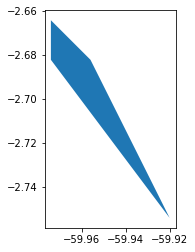

In [877]:
poly0.convex_hull.plot()

In [972]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Point, Polygon

# Initialize a test GeoDataFrame where geometry is a list of points
df = gp.GeoDataFrame( [['box', Point(1, 0)], 
                       ['box', Point(1, 1)], 
                       ['box', Point(2,2)], 
                       ['box', Point(1,2)]],  
                     columns = ['shape_id', 'geometry'], 
                     geometry='geometry')

# # Extract the coordinates from the Point object
df['geometry'] = df['geometry'].apply(lambda x: x.coords[0])

# # Group by shape ID 
# #  1. Get all of the coordinates for that ID as a list
# #  2. Convert that list to a Polygon
# df = df.groupby('shape_id')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()

# # Declare the result as a new a GeoDataFrame
# df = gp.GeoDataFrame(df, geometry = 'geometry')

# df.plot()

In [973]:
df

,shape_id,geometry
0,box,"(1.0, 0.0)"
1,box,"(1.0, 1.0)"
2,box,"(2.0, 2.0)"
3,box,"(1.0, 2.0)"


In [1074]:
from PIL import Image
import numpy as np

# create data
d = np.ndarray(shape=(10,20), dtype=np.float32)
d[()] = np.arange(200).reshape(10, 20)

im = Image.fromarray(d, mode='F') # float32
im.save("test2.tiff", "TIFF")